<a href="https://colab.research.google.com/github/KimaniKibuthu/Delay-Prediction/blob/main/Flight_delay_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flight Delay Prediction
The aim of this project is to predict whether a flight would be delayed or not.

# Introduction
The flow of the project will include:
* Data retrieval
* Exploratory Data Analysis
* Modelling

# Install  & Import Libraries

## Install Libraries


In [ ]:
# Uninstall existing CUDA 
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-304-updates-dev' for glob 'nvidia*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-340-updates-uvm' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-source-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-331-updates-uvm' for glob 'nvidi

In [ ]:
# Install the latest CUDA
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2

--2021-02-24 06:01:26--  https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 152.199.0.24
Connecting to developer.nvidia.com (developer.nvidia.com)|152.199.0.24|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 [following]
--2021-02-24 06:01:26--  https://developer.nvidia.com/compute/cuda/9.2/prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb?mF1htOopGwYTcjPBmRdQSxhqftN-aQk7HK1V-A5hPFw8bMgQ7a0MwqQxquEEzdnYxcfZX_Qzo9we6FB8OwQpvqyMpl8KlbMVkQvCoKk2RnB_3eNNc

In [ ]:
# Install the plugin
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-zxiu4haf
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-zxiu4haf
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp37-none-any.whl size=4307 sha256=4c5cb93eb44130f49f9f72c3fb18635102ed7f90438758f1b6042c23d5d59f0a
  Stored in directory: /tmp/pip-ephem-wheel-cache-8r2i88w0/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin


In [ ]:
# Load the plug in
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


In [ ]:
# Install kaggle
! pip install kaggle

In [ ]:
# install catboost
! pip install catboost


     |████████████████████████████████| 65.7MB 47kB/s 


## Import Libraries

In [ ]:
# import the necessary libraries

# Support libraries
import os
import shutil
from zipfile import ZipFile

# EDA libraries
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from catboost import CatBoostClassifier

# Data Retrieval

In [ ]:
# Set up the environment to load data from
os.environ["KAGGLE_USERNAME"] = #Kaggle name
os.environ["KAGGLE_KEY"] = #Kaggle Key

In [ ]:
# Download the data from the kaggle competition

data_dir = "data/"

!kaggle competitions download -c flight-delays-fall-2018 -p {data_dir}

  0% 0.00/385k [00:00<?, ?B/s]
100% 385k/385k [00:00<00:00, 60.3MB/s]
  0% 0.00/1.00M [00:00<?, ?B/s]
100% 1.00M/1.00M [00:00<00:00, 67.0MB/s]
  0% 0.00/1.04M [00:00<?, ?B/s]
100% 1.04M/1.04M [00:00<00:00, 150MB/s]


In [ ]:
# Unzip the train data first
zip_train = ZipFile('/content/data/flight_delays_train.csv.zip', 'r')
zip_train.extractall('/content/input/')

# Unzip the test data 
zip_test = ZipFile('/content/data/flight_delays_test.csv.zip', 'r')
zip_test.extractall('/content/input/')

# Unzip the sample submission
zip_sample_submission = ZipFile('/content/data/sample_submission.csv.zip', 'r')
zip_sample_submission.extractall('/content/input/')

In [ ]:
# Save in a variable for exploration
flight_delay_df = pd.read_csv('/content/input/flight_delays_train.csv')

In [ ]:
# Save test data in a variable
test = pd.read_csv('/content/input/flight_delays_test.csv')

In [ ]:
# Sample csv
sample = pd.read_csv('/content/input/sample_submission.csv')

# Exploratory Data Analysis
The goal here is to clean the data, explore it and transform it for modelling purposes.

## Explore the data


In [ ]:
# Look at a sample of the data
flight_delay_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [ ]:
# Look at the info
flight_delay_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


The data has 100,000 entries with zero null values. Let's now look at the distribution of the data.

### Target Column (dep_delayed_15min)

In [ ]:
# Let's rename the column to state of delay
flight_delay_df.rename(columns={'dep_delayed_15min': 'state_of_delay'}, 
                       inplace=True)

In [ ]:
# See the unique values
flight_delay_df.state_of_delay.value_counts()

N    80956
Y    19044
Name: state_of_delay, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


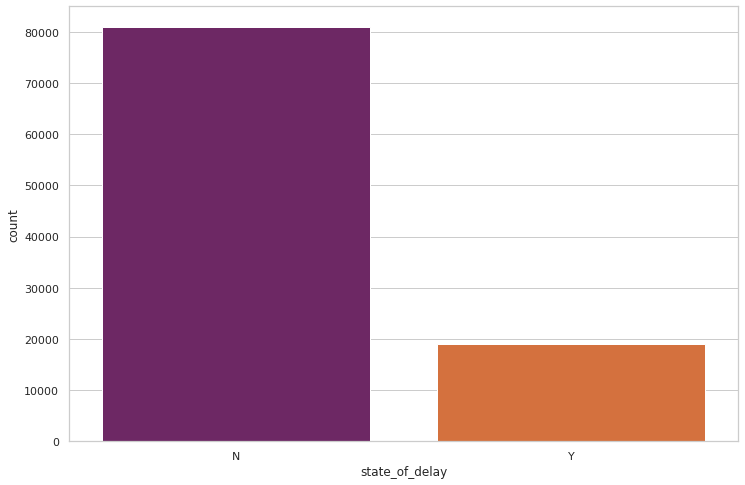

In [ ]:
# Visualize the value counts
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('whitegrid')
sns.countplot('state_of_delay', data=flight_delay_df, palette='inferno')

There is some imbalance in our class labels, hence we will have to deal with that.

In [ ]:
# Convert to numerical
mapping = {'N': 0,
           'Y': 1}

flight_delay_df['state_of_delay'] = flight_delay_df['state_of_delay'].map(mapping)

### Month

In [ ]:
# Let's generate a cleaner 
def date_cleaner(date_column, dataset):
  ''' Cleans the date columns, converting the values to integers. 
       Eg 'c-8' to 8 '''
  # Get column values
  for column in date_column:
    column_values = dataset[column].values

    # Clean the values
    for index, value in enumerate(column_values):
      column_values[index] = int(value.split('-')[1])

    # Convert the new values to a dataframe and append to the new dataframe
    dataset[column] = pd.Series(column_values)

  
  return dataset



In [ ]:
# Convert all the columns to integer values
flight_delay_clean = date_cleaner(['Month', 'DayofMonth', 'DayOfWeek'],
                                  flight_delay_df)

In [ ]:
# Check the distribution
flight_delay_clean.Month.describe()

count     100000
unique        12
top            8
freq        8830
Name: Month, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


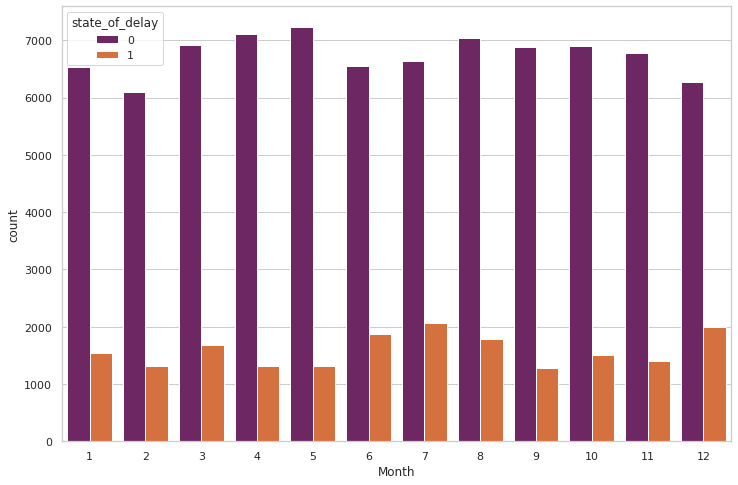

In [ ]:
# Visualize the relationship between Month and delay
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('whitegrid')
sns.countplot('Month',
              hue='state_of_delay', 
              data=flight_delay_clean,
              palette='inferno')

There is seasonality on the increase of air travel. There is a significant rise of delays in June, July and December despite the flight count being lower.

### Unique Carrier

In [ ]:
# Check the distribution
flight_delay_clean.UniqueCarrier.describe()

count     100000
unique        22
top           WN
freq       15082
Name: UniqueCarrier, dtype: object

In [ ]:
flight_delay_clean.UniqueCarrier.unique()

array(['AA', 'US', 'XE', 'OO', 'WN', 'NW', 'DL', 'OH', 'AS', 'UA', 'MQ',
       'CO', 'EV', 'DH', 'YV', 'F9', 'AQ', 'TZ', 'HP', 'B6', 'FL', 'HA'],
      dtype=object)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


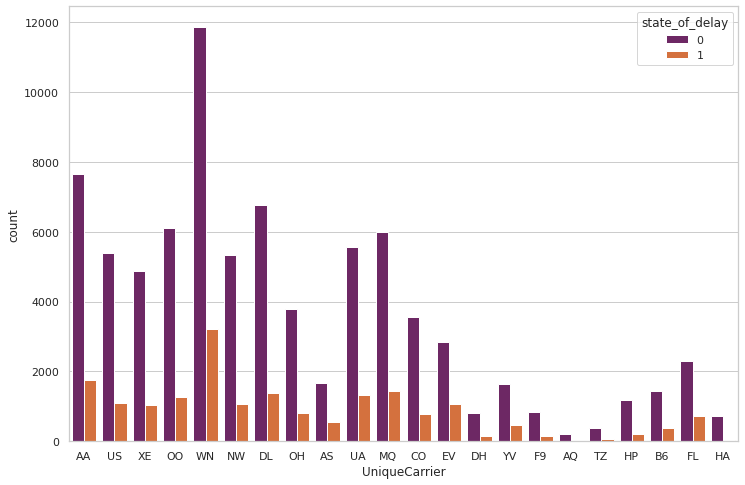

In [ ]:
# See how it affects delay
# Visualize the relationship between Unique Carrier and delay
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('whitegrid')
sns.countplot('UniqueCarrier',
              hue='state_of_delay', 
              data=flight_delay_clean,
              palette='inferno')

The more flights a carrier has, the more it is likely to endure delays

### Origin Airport

In [ ]:
# Check the distribution
flight_delay_clean.Origin.describe()

count     100000
unique       289
top          ATL
freq        5834
Name: Origin, dtype: object

In [ ]:
# Check value Counts
flight_delay_clean.Origin.value_counts()

ATL    5834
ORD    4870
DFW    4270
LAX    3259
IAH    3048
       ... 
VCT       1
VIS       1
GST       1
ADK       1
ILG       1
Name: Origin, Length: 289, dtype: int64

In [ ]:
flight_delay_clean.Origin.unique()

array(['ATL', 'PIT', 'RDU', 'DEN', 'MDW', 'MEM', 'PBI', 'MSP', 'ONT',
       'BDL', 'PHX', 'LAS', 'DFW', 'DSM', 'CMH', 'ORF', 'SLC', 'CLT',
       'GSO', 'IAD', 'SMF', 'FLL', 'DAL', 'ORD', 'ITO', 'SAN', 'ROA',
       'LGA', 'SFO', 'GSP', 'SEA', 'DAB', 'SJC', 'LIT', 'LAX', 'OAK',
       'COS', 'OKC', 'GRR', 'JFK', 'BOI', 'MCI', 'BWI', 'BHM', 'CRP',
       'BOS', 'SAT', 'PHL', 'STL', 'CIC', 'AUS', 'IAH', 'COD', 'HNL',
       'RNO', 'BNA', 'TPA', 'MIA', 'EVV', 'PNS', 'EWR', 'RSW', 'ANC',
       'SNA', 'AMA', 'CID', 'DTW', 'DCA', 'LGB', 'MAF', 'MFE', 'BMI',
       'PDX', 'IPL', 'GRB', 'FAR', 'HOU', 'MTJ', 'DRO', 'MLU', 'VPS',
       'TUL', 'CVG', 'SBA', 'PWM', 'IDA', 'MCO', 'ACV', 'CHS', 'BGM',
       'MSY', 'OGG', 'CLE', 'MOB', 'CAK', 'FAY', 'SHV', 'TUS', 'IND',
       'CAE', 'PVD', 'ROC', 'MFR', 'VLD', 'ELP', 'RIC', 'MKE', 'SGF',
       'TYS', 'CHO', 'EGE', 'BIS', 'JAN', 'JAX', 'BUF', 'MSO', 'BGR',
       'CEC', 'ICT', 'MYR', 'ALB', 'LIH', 'SBP', 'AEX', 'GNV', 'SAV',
       'BTM', 'BRO',

### Departure Airport


In [ ]:
# Check the distribution
flight_delay_clean.Dest.describe()

count     100000
unique       289
top          ATL
freq        5795
Name: Dest, dtype: object

In [ ]:
# Check value Counts
flight_delay_clean.Dest.value_counts()

ATL    5795
ORD    4933
DFW    4337
LAX    3205
IAH    3056
       ... 
TTN       1
TEX       1
LWB       1
ACK       1
VCT       1
Name: Dest, Length: 289, dtype: int64

### Departure Time

In [ ]:
# Clean the time
def hour_extractor(time_column, data, drop_time=True):
  ''' Extracts the hour from the time column'''
  # Extract the values as a string
  time = data[time_column].values.astype(str)

  # Convert to the format (00:00)
  for index, value in enumerate(time):
      if len(value) == 1:
        time[index] = f'000{value}'
      if len(value) == 2:
        time[index] = f'00{value}'
      if len(value) == 3:
        time[index] = f'0{value}'
  
  for index, value in enumerate(time):
    time[index] = f'{value[0]}{value[1]}:{value[2]}{value[3]}'
  
  # Split the new time to obtain the hour
  hour = []
  for value in time:
      x = int(value.split(':')[0])
      hour.append(x)
  # Convert 24 and 25 to 0 and 1     
  for index, value in enumerate(hour):
    if value == 24:
      hour[index] = 0
    elif value == 25:
      hour[index] = 1
      
  # Convert Hour to dataFrame and append to the data
  Hour = pd.DataFrame(np.array(hour), columns=['Hour'])

  # Append to the dataset
  new_dataset = pd.concat([data, Hour], axis=1)

  if drop_time:
    new_dataset = new_dataset.drop(time_column, axis=1)
  

  return new_dataset





In [ ]:
# Create minute column
flight_delay_clean['minute'] = flight_delay_clean['DepTime'] % 100

In [ ]:
# Create an hours column
flights_delays_cleaner = hour_extractor('DepTime', 
                                        data=flight_delay_clean, 
                                        drop_time=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


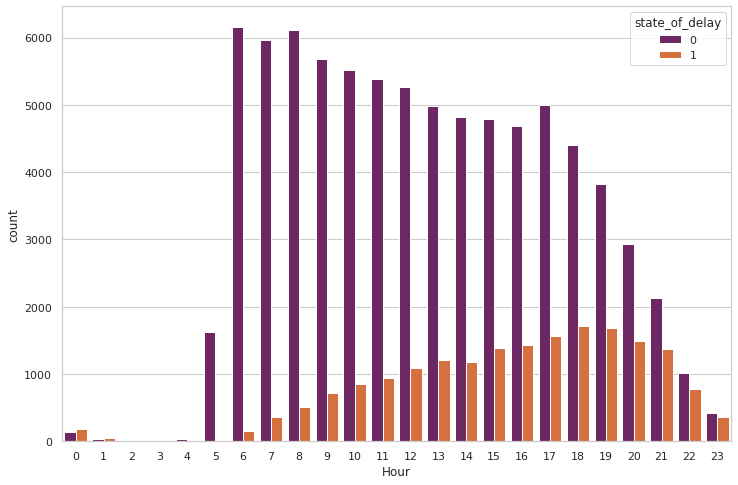

In [ ]:
# View the effect on delay

sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('whitegrid')
sns.countplot('Hour',
              hue='state_of_delay', 
              data=flights_delays_cleaner,
              palette='inferno')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


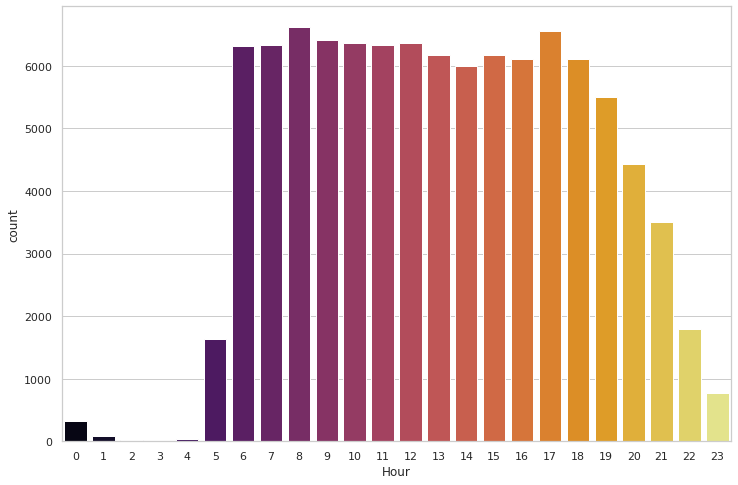

In [ ]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('whitegrid')
sns.countplot('Hour', 
              data=flights_delays_cleaner,
              palette='inferno')

There are more delays in the afternoon and in the night despite the flights being the same count.

In [ ]:
# create hour squared and powerd to 4 to give hour more emphasis

flights_delays_cleaner['hour_squared'] = flights_delays_cleaner['Hour'] ** 2


### Range 

In [ ]:
# Bin the distance
flights_delays_cleaner.loc[flights_delays_cleaner.Distance <= 500 , 'Dist_bin'] = 'vshort'
flights_delays_cleaner.loc[(flights_delays_cleaner.Distance > 500) & (flights_delays_cleaner.Distance <= 1000), 'Dist_bin'] = 'short'
flights_delays_cleaner.loc[(flights_delays_cleaner.Distance > 1000) & (flights_delays_cleaner.Distance <= 1500), 'Dist_bin'] = 'mid'
flights_delays_cleaner.loc[(flights_delays_cleaner.Distance > 1500) & (flights_delays_cleaner.Distance <= 2000), 'Dist_bin'] = 'midlong'
flights_delays_cleaner.loc[(flights_delays_cleaner.Distance > 2000) & (flights_delays_cleaner.Distance <= 2500), 'Dist_bin'] = 'long'
flights_delays_cleaner.loc[flights_delays_cleaner.Distance > 2500, 'Dist_bin'] = 'vlong'


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


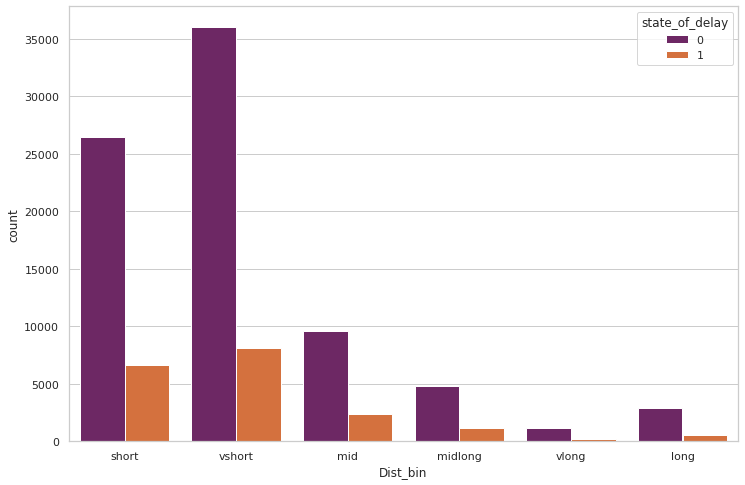

In [ ]:
# View how holidays affect delays
sns.set(rc={'figure.figsize':(12, 8)})
sns.set_style('whitegrid')
sns.countplot('Dist_bin',
              hue='state_of_delay', 
              data=flights_delays_cleaner,
              palette='inferno')

## Transform the data for modelling

### Encode Month, Day of Month, Day of Week and Holiday

In [ ]:
# Convert the datatype the time columns
time_columns = ['Month', 'DayofMonth', 'DayOfWeek']

for column in time_columns:
  flights_delays_cleaner[column]=flights_delays_cleaner[column].astype(dtype=np.int64)

### Create New Columns

In [ ]:
# Create new column binning hour flights_delays_cleaner
flights_delays_cleaner
flights_delays_cleaner.loc[flights_delays_cleaner.Hour < 6 , 'DepTime_bin'] = 'vem'
flights_delays_cleaner.loc[(flights_delays_cleaner.Hour >= 6) & (flights_delays_cleaner.Hour <= 9), 'DepTime_bin'] = 'm'
flights_delays_cleaner.loc[(flights_delays_cleaner.Hour > 9) & (flights_delays_cleaner.Hour <= 12), 'DepTime_bin'] = 'mm'
flights_delays_cleaner.loc[(flights_delays_cleaner.Hour > 12) & (flights_delays_cleaner.Hour <= 15), 'DepTime_bin'] = 'maf'
flights_delays_cleaner.loc[(flights_delays_cleaner.Hour > 15) & (flights_delays_cleaner.Hour <= 18), 'DepTime_bin'] = 'af'
flights_delays_cleaner.loc[(flights_delays_cleaner.Hour > 18) & (flights_delays_cleaner.Hour <= 21), 'DepTime_bin'] = 'n'
flights_delays_cleaner.loc[(flights_delays_cleaner.Hour > 21) & (flights_delays_cleaner.Hour <= 23), 'DepTime_bin'] = 'nn'



In [ ]:
# Combine the Origin an dest column
flights_delays_cleaner['Route'] = flights_delays_cleaner['Origin'] + flights_delays_cleaner['Dest']


In [ ]:
# Combine Dest and Origin with Unique Carrier
flights_delays_cleaner['UniqueCarrier_Origin'] = flights_delays_cleaner['UniqueCarrier'] + "_" + flights_delays_cleaner['Origin']
flights_delays_cleaner['UniqueCarrier_Dest'] = flights_delays_cleaner['UniqueCarrier'] + "_" + flights_delays_cleaner['Dest']

In [ ]:
# Combine columns
flights_delays_cleaner['h-carrier'] = flights_delays_cleaner['hour_squared'].astype('str') + '_' + flights_delays_cleaner['UniqueCarrier']
flights_delays_cleaner['M_Origin_carrier'] = flights_delays_cleaner['Month'].astype('str') + '_' +  flights_delays_cleaner['UniqueCarrier_Origin']
flights_delays_cleaner['M_Dest_carrier'] = flights_delays_cleaner['Month'].astype('str') + '_' +  flights_delays_cleaner['UniqueCarrier_Dest']

flights_delays_cleaner['H_Dest_carrier'] = flights_delays_cleaner['hour_squared'].astype('str') + '_' +  flights_delays_cleaner['UniqueCarrier_Dest']
flights_delays_cleaner['H_Origin_carrier'] = flights_delays_cleaner['hour_squared'].astype('str') + '_' +  flights_delays_cleaner['UniqueCarrier_Origin']


flights_delays_cleaner['Dep_Dist'] = flights_delays_cleaner['DepTime_bin'].astype('str') + '_' +  flights_delays_cleaner['Dist_bin']
flights_delays_cleaner['Dep_Route'] = flights_delays_cleaner['DepTime_bin'].astype('str') + '_' +  flights_delays_cleaner['Route']


### Drop unnecessary columns

In [ ]:
# Drop unnecessary columns
flights_delays_cleaner = flights_delays_cleaner.drop(
    [ 'Distance', 'Origin', 'Dest', 
     'DayOfWeek','Hour', 'DayofMonth', 'UniqueCarrier'], axis=1)

In [ ]:
flights_delays_cleaner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Month                 100000 non-null  int64 
 1   state_of_delay        100000 non-null  int64 
 2   minute                100000 non-null  int64 
 3   hour_squared          100000 non-null  int64 
 4   Dist_bin              100000 non-null  object
 5   DepTime_bin           100000 non-null  object
 6   Route                 100000 non-null  object
 7   UniqueCarrier_Origin  100000 non-null  object
 8   UniqueCarrier_Dest    100000 non-null  object
 9   h-carrier             100000 non-null  object
 10  M_Origin_carrier      100000 non-null  object
 11  M_Dest_carrier        100000 non-null  object
 12  H_Dest_carrier        100000 non-null  object
 13  H_Origin_carrier      100000 non-null  object
 14  Dep_Dist              100000 non-null  object
 15  Dep_Route         

In [ ]:
# Choose features to use
to_use = ['minute', 'Dep_Route', 'hour_squared', 'H_Dest_carrier',
       'h-carrier', 'H_Origin_carrier','Route', 'M_Origin_carrier',
       'M_Dest_carrier', 'state_of_delay']

In [ ]:
flights_final = flights_delays_cleaner[to_use]

### Split data

In [ ]:
# Split data

x = flights_final.drop(['state_of_delay'], axis=1)
y = flights_final['state_of_delay']

x = x.rename(columns={
                   'Dep_Route':'departure_route', 
                   'H_Dest_carrier':'h_destination_carrier', 
                   'h-carrier':'h_carrier',
                   'H_Origin_carrier':'h_origin_carrier', 
                   'Route':'route',
                   'M_Origin_carrier':'m_origin_carrier', 
                   'M_Dest_carrier':'m_destination_carrier'})

x_train, x_preliminary, y_train, y_preliminary = train_test_split(x,
                                                   y,
                                                   random_state=42,
                                                   stratify=y,
                                                   train_size=0.8)

x_val, x_test, y_val, y_test = train_test_split(x_preliminary,
                                                   y_preliminary,
                                                   random_state=42,
                                                   stratify=y_preliminary,
                                                   test_size=0.5)

In [ ]:
# Specify cat_features
categoricals = [v for v in x.columns if x[v].dtype == 'O']

In [ ]:
categoricals

['departure_route',
 'h_destination_carrier',
 'h_carrier',
 'h_origin_carrier',
 'route',
 'm_origin_carrier',
 'm_destination_carrier']

In [ ]:
# Reset index
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

x_val = x_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [ ]:
x_train

,minute,departure_route,hour_squared,h_destination_carrier,h_carrier,h_origin_carrier,route,m_origin_carrier,m_destination_carrier
0,28,mm_BWICLT,144,144_FL_CLT,144_FL,144_FL_BWI,BWICLT,6_FL_BWI,6_FL_CLT
1,20,af_ORDDCA,256,256_AA_DCA,256_AA,256_AA_ORD,ORDDCA,11_AA_ORD,11_AA_DCA
2,43,vem_MEMATL,25,25_DL_ATL,25_DL,25_DL_MEM,MEMATL,3_DL_MEM,3_DL_ATL
3,25,n_OAKSEA,361,361_WN_SEA,361_WN,361_WN_OAK,OAKSEA,9_WN_OAK,9_WN_SEA
4,22,m_LAXMSP,36,36_NW_MSP,36_NW,36_NW_LAX,LAXMSP,12_NW_LAX,12_NW_MSP
...,...,...,...,...,...,...,...,...,...
79995,56,n_PHLCLT,400,400_US_CLT,400_US,400_US_PHL,PHLCLT,6_US_PHL,6_US_CLT
79996,30,m_GRRLGA,36,36_MQ_LGA,36_MQ,36_MQ_GRR,GRRLGA,12_MQ_GRR,12_MQ_LGA
79997,25,maf_GSOCLT,225,225_YV_CLT,225_YV,225_YV_GSO,GSOCLT,1_YV_GSO,1_YV_CLT
79998,10,maf_ATLABY,169,169_EV_ABY,169_EV,169_EV_ATL,ATLABY,12_EV_ATL,12_EV_ABY


In [ ]:
# Set weights based on distribution of classes
weights = {
    0:0.6176,
    1:2.6254
}

# Modelling
Lets model using catboost

## Training & Evaluation
Train the model and evaluate it using training and validation data

In [ ]:
# Instantiate the model
cat_classifier = CatBoostClassifier(iterations=2000,
                                    learning_rate=0.05,
                                    cat_features=categoricals,
                                    class_weights=weights,
                                    verbose=False, 
                                    random_seed=0,
                                    bagging_temperature= 0.0,
                                    depth= 5,
                                    l2_leaf_reg= 12,
                                    random_strength= 1e-05
                                    
                                    )



cat_classifier.fit(x_train, y_train, eval_set=(x_val, y_val))
preds = cat_classifier.predict_proba(x_val)[:,1]
score = roc_auc_score(y_val, preds)


print(f'The Validation Data ROC score is: {score}')

The Validation Data ROC score is: 0.8186743704597149


In [ ]:
# Evaluate on the test set
predictions = cat_classifier.predict_proba(x_test)[:,1]
score = roc_auc_score(y_test, predictions)
print(f'The Test Data ROC score is: {score}')

The Test Data ROC score is: 0.831144633619258


In [ ]:
# Check for feature importances
def plot_feature_importance(trained_model, features_train):

    #Create arrays from feature importance and feature names
    feature_importance = trained_model.get_feature_importance()
    feature_names = features_train.columns

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.set_style('whitegrid')
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],
                palette='husl')
    #Add chart labels
    plt.title('FEATURE IMPORTANCES')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

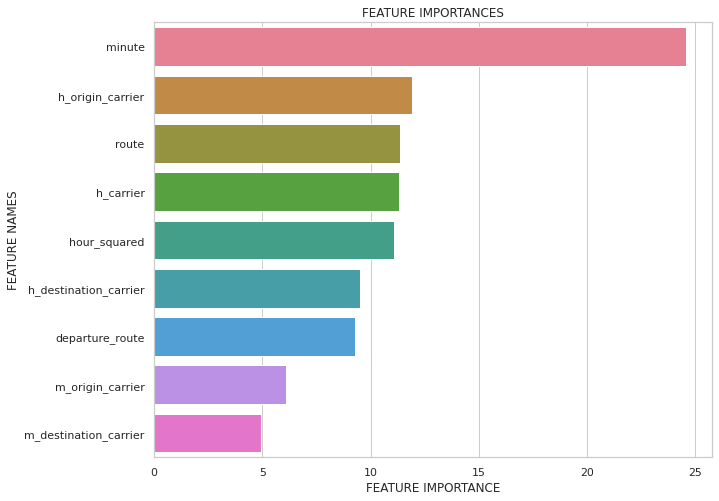

In [ ]:
plot_feature_importance(cat_classifier, x_train)

In [ ]:
# Save the model
cat_classifier.save_model('best_model.cbm', format='cbm')


In [ ]:
# Save pickle model